# Analiza i predikcija kratkoročnih logaritamskih prinosa S&P 500 indeksa primenom modela vremenskih serija

**Autor:** Miloš Trišić RA39/2023  
**Predmet:** Numerički algoritmi i numerički softver (NANS)  

---

## 0. Uvod i opis problema

**S&P 500** (Standard & Poor's 500) je berzanski indeks koji prati kretanje 500 najvećih američkih kompanija po tržišnoj kapitalizaciji. Ovaj indeks je kapitalizacijski ponderisan, što znači da kompanije poput Apple-a, Microsoft-a i NVIDIA-e imaju veći uticaj na njegovo kretanje od manjih kompanija. Zbog toga ga mnogi ekonomisti smatraju najboljim pokazateljem stanja američke ekonomije u celini.

Cilj ovog projekta je ispitati u kojoj meri savremeni modeli vremenskih serija mogu da se primene za analizu i kratkoročnu predikciju kretanja ovog indeksa (tačnije njegovih logaritamskih prinosa "log-returns" - objašnjeno u nastavku). Konkretno:

- Analiza i identifikacija osnovnih karakteristika serije (trend, sezonalnost, cikličnost, šum)
- Predikcija pomoću **ARIMA** i **Facebook Prophet** modela
- Modelovanje volatilnosti pomoću **GARCH** modela
- Deskriptivna **PCA** analiza kompanija i sektora koji najviše doprinose varijansi tržišta

### Zbog čega je modelovanje ovakvih pojava problematično?

Finansijska tržišta su po prirodi veoma kompleksna – na vrednost indeksa istovremeno utiče veliki broj faktora (makroekonomski pokazatelji, geopolitika, raspoloženje investitora, izveštaji kompanija, kao i mnogobrojni nepredvidivi faktori...). Zbog toga ćemo videti da modeli vremenskih serija imaju ograničene performanse u smislu tačne predikcije vrednosti, ali nam i dalje daju korisne uvide o **strukturi serije** i **dinamici volatilnosti**.

### Horizont predikcije

Predikciju vršimo za **1 trading dan unapred**, koristeći walk-forward evaluaciju na test skupu. Razlog za ovako kratak horizont je propagacija greške – što dalje predviđamo, interval neizvesnosti eksponencijalno raste, pa su predikcije duže od 2-3 dana za finansijske serije uglavnom nepouzdane.

---
## 1. Učitavanje podataka i pretprocesiranje

Pre nego što krenemo na analizu i modelovanje, učitavamo podatke, sređujemo ih i delimo na skupove za trening, validaciju i testiranje.

### Podela podataka

Kod vremenskih serija podela mora biti **strogo hronološka** – ne možemo koristiti  random-split kao kod klasičnih ML problema. Ako bi podaci iz budućnosti ušli u trening skup, model bi imao informacije koje u realnosti ne bi imao u trenutku predikcije (*data leakage*). Dakle, koristimo sledeću podelu:

| Skup | Period | Napomena |
|------|--------|----------|
| **Train** | 2014-12-23 → 2022-12-30 | Uključuje COVID krizu (2020) i tržišni pad (2022) |
| **Validation** | 2023-01-03 → 2023-12-29 | Za određivanje parametara modela |
| **Test** | 2024-01-02 → 2024-12-20 | Finalna evaluacija – ne koristimo dok ne dobijemo finalne verzije modela spremne za testiranje |

Validacioni skup koristimo tokom razvoja za odabir parametara (npr. p, d, q za ARIMA). Test skup koristimo **samo jednom**, na kraju, za finalno poređenje karakteristika dobijenih modela.

In [8]:
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

print('Biblioteke uspešno učitane.')

Biblioteke uspešno učitane.


In [9]:
from src.preprocessing import load_and_prepare, print_split_info

train, val, test, companies = load_and_prepare(
    index_path     = 'data/sp500_index.csv',
    companies_path = 'data/sp500_companies.csv'
)

print_split_info(train, val, test)

       Train: 2014-12-23 → 2022-12-30 | 2020 trading dana (80.3%)
  Validation: 2023-01-03 → 2023-12-29 |  250 trading dana (9.9%)
        Test: 2024-01-02 → 2024-12-20 |  246 trading dana (9.8%)
      Ukupno: 2516 trading dana


### Pregled učitanih tabela

Koristimo tabele :
- `sp500_index.csv` – dnevne zatvarajuće vrednosti indeksa za svaki trading dan (vikendi i praznici su prirodno odsutni)
- `sp500_companies.csv` – metapodaci o kompanijama: sektor, industrija, tržišna kapitalizacija, ponder u indeksu itd. Ova tabela koristiće mi u PCA analizi.

In [10]:
print('=== Prvih 5 redova (train) ===')
display(train.head())

print('\n=== Poslednjih 5 redova (train) ===')
display(train.tail())

print('\n=== Prvih 5 redova (test) ===')
display(test.head())

=== Prvih 5 redova (train) ===


,S&P500,log_return
Date,,
2014-12-23,2082.17,0.001745
2014-12-24,2081.88,-0.000139
2014-12-26,2088.77,0.003304
2014-12-29,2090.57,0.000861
2014-12-30,2080.35,-0.004901



=== Poslednjih 5 redova (train) ===


,S&P500,log_return
Date,,
2022-12-23,3844.82,0.005851
2022-12-27,3829.25,-0.004058
2022-12-28,3783.22,-0.012093
2022-12-29,3849.28,0.017311
2022-12-30,3839.50,-0.002544



=== Prvih 5 redova (test) ===


,S&P500,log_return
Date,,
2024-01-02,4742.83,-0.005677
2024-01-03,4704.81,-0.008049
2024-01-04,4688.68,-0.003434
2024-01-05,4697.24,0.001824
2024-01-08,4763.54,0.014016


In [11]:
cols = ['Symbol', 'Shortname', 'Sector', 'Marketcap', 'Weight']
print(f'Broj kompanija: {len(companies)}')
print(f'Broj sektora:   {companies["Sector"].nunique()}')
print()
display(companies[cols].head(10))

Broj kompanija: 502
Broj sektora:   11



,Symbol,Shortname,Sector,Marketcap,Weight
0,AAPL,Apple Inc.,Technology,3846819807232,0.069209
1,NVDA,NVIDIA Corporation,Technology,3298803056640,0.059350
2,MSFT,Microsoft Corporation,Technology,3246068596736,0.058401
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,2365033807872,0.042550
4,GOOGL,Alphabet Inc.,Communication Services,2351625142272,0.042309
5,GOOG,Alphabet Inc.,Communication Services,2351623045120,0.042309
6,META,"Meta Platforms, Inc.",Communication Services,1477457739776,0.026581
7,TSLA,"Tesla, Inc.",Consumer Cyclical,1351627833344,0.024317
8,AVGO,Broadcom Inc.,Technology,1031217348608,0.018553
9,BRK-B,Berkshire Hathaway Inc. New,Financial Services,978776031232,0.017609


In [12]:
#Agregacija broja kompanija i ukupne težine (kolona Weights) po sektorima
sektor_count = companies.groupby('Sector').agg(
    Broj_kompanija=('Symbol', 'count'),
    Weight=('Weight', 'sum')
).sort_values('Weight', ascending=False).round(4)

display(sektor_count)

,Broj_kompanija,Weight
Sector,,
Technology,82,0.3110
Communication Services,22,0.1404
Financial Services,67,0.1279
Consumer Cyclical,55,0.1146
Healthcare,62,0.0934
Industrials,70,0.0677
Consumer Defensive,37,0.0585
Energy,22,0.0288
Utilities,32,0.0226


---
## 2. Vizualizacija i eksplorativna analiza podataka (EDA)

### 2.1 Zašto ne modelujemo originalne vrednosti indeksa direktno?

Pre nego što transformišemo podatke, pogledajmo kako izgleda originalna vrednost S&P 500 indeksa kroz ceo posmatrani period. Na osnovu onoga što vidimo, donećemo zaključke o tome šta zapravo treba da modelujemo.

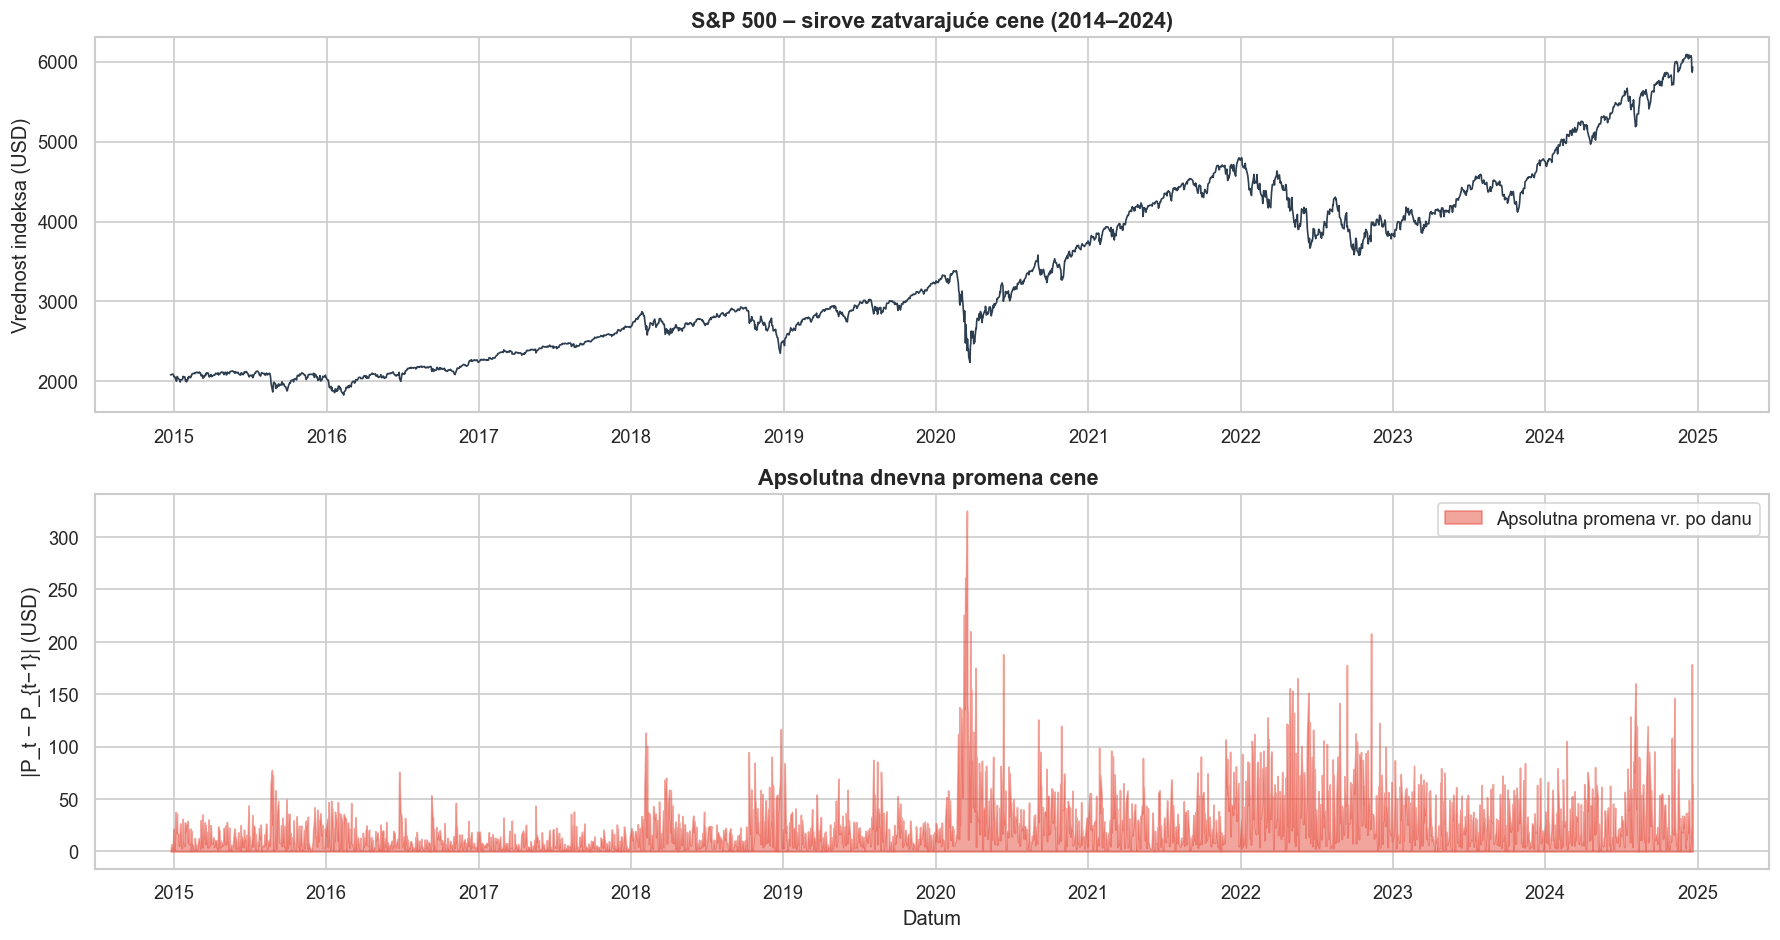

In [13]:
full_df = pd.concat([train, val, test])

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ── Gornji grafik: originalne vrednosti ─────────────────────────────────────────
axes[0].plot(full_df.index, full_df['S&P500'], color='#2c3e50', linewidth=1.0)
axes[0].set_title('S&P 500 – sirove zatvarajuće cene (2014–2024)',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Vrednost indeksa (USD)')

# ── Donji grafik: apsolutna dnevna promena ─────────────────────────────
abs_changes = full_df['S&P500'].diff().abs()
axes[1].fill_between(full_df.index, abs_changes,
                     color='#e74c3c', alpha=0.5, label='Apsolutna promena vr. po danu')
axes[1].set_title('Apsolutna dnevna promena cene ',
                   fontsize=13, fontweight='bold')
axes[1].set_ylabel('|P_t − P_{t−1}| (USD)')
axes[1].set_xlabel('Datum')
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

Sa grafika možemo uočiti dva problema koja direktnu primenu modela na vrednost indeksa čine problematičnom :

1. **Jasan rastući trend** – indeks je porastao sa ~2000 na ~6000 USD tokom posmatranog perioda. Serija nema konstantnu srednju vrednost, što znači da **nije stacionarna**. Stacionarnost je osnovna pretpostavka ARIMA i srodnih modela, pa direktna primena na originalnu vrednost indeksa nije moguća.

2. **Varijansa raste sa trendom** – apsolutne dnevne promene su neuporedivo veće u 2024. nego 2015. Ovo ukazuje na **multiplikativni karakter** serije.

Oba problema rešavamo jednom transformacijom – prelaskom na logaritamske prinose.